# The `opencadd.structure.pocket` module

Let's walk through the functionalities offered in the `opencadd.structure.pocket` module.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd

from opencadd.databases.klifs import setup_remote
from opencadd.structure.pocket import Pocket, KlifsPocket, PocketViewer

INFO:opencadd.databases.klifs.api:If you want to see an non-truncated version of the DataFrames in this module, use `pd.set_option('display.max_columns', 50)` in your notebook.


## Get example protein structure and pocket residues

In [3]:
from opencadd.databases.klifs import setup_remote
remote = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


__Download protein structure file (or use your own file)__

First of all, we download structural data for an example protein kinase with PDB ID `4wsq` alternate model A and chain A from the KLIFS database:

https://klifs.net/details.php?structure_id=3834

In [4]:
structure_klifs_id = 3834

In [5]:
text = remote.coordinates.to_text(structure_klifs_id)

__Fetch pocket residues (or use your own pocket residues)__



In [6]:
pocket_residues = remote.pockets.by_structure_klifs_id(structure_klifs_id)
pocket_residues

,residue.klifs_id,residue.id,residue.klifs_region_id,residue.klifs_region,residue.klifs_color
0,1,50,I.1,I,khaki
1,2,51,I.2,I,khaki
2,3,52,I.3,I,khaki
3,4,53,g.l.4,g.l,green
4,5,54,g.l.5,g.l,green
...,...,...,...,...,...
80,81,194,xDFG.81,xDFG,cornflowerblue
81,82,195,xDFG.82,xDFG,cornflowerblue
82,83,196,xDFG.83,xDFG,cornflowerblue
83,84,197,a.l.84,a.l,cornflowerblue


In [7]:
pocket_residue_ids = pocket_residues["residue.id"].to_list()
print("Pocket residue PDB IDs:")
print(*pocket_residue_ids)
pocket_residue_ixs = pocket_residues["residue.klifs_id"].to_list()
print("Pocket residue (KLIFS) indices:")
print(*pocket_residue_ixs)

Pocket residue PDB IDs:
50 51 52 53 54 55 56 57 58 59 60 61 62 71 72 73 74 75 76 86 87 88 89 90 91 92 93 94 95 96 97 98 101 102 103 104 105 106 107 108 109 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 192 193 194 195 196 197 198
Pocket residue (KLIFS) indices:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85


## Pocket (`Pocket` class)

The `Pocket` class currently holds the following attributes/properties:

- `name`: Protein/pocket name
- `filepath`: Path to file with structural protein data
- `centroid`: Centroids of all pocket residues' CA atoms
- `subpockets`: Subpockets defined based on a set of anchor residues each
- `regions`: User-defined regions that are of importance for the protein/pocket
- `anchor_residues`: Anchor residues to define one or more subpockets

### Initialize pocket

We initialize the pocket with the following parameters:
- Protein structure data
- Protein/pocket name
- Pocket residues PDB IDs
- Pocket residue indices (optionally), e.g. for the pocket alignment IDs

In [8]:
pocket = Pocket.from_text(
    text,
    "mol2",
    pocket_residue_ids, 
    pocket_residue_ixs,
    name=structure_klifs_id
)

Let's take a look at key `Pocket` class attributes/properties after initialization.

__Pocket centroids__

In [9]:
pocket.center

array([ 1.1348164, 20.79171  , 36.3045   ], dtype=float32)

### Add subpockets

Next, we can add subpockets one-by-one to the pocket. For each subpocket we define the following:
- Subpocket __name__
- __Residue PDB IDs__ OR __residue indices__ (e.g. alignment indices) of all __anchor residues__, i.e. the residues determining the subpocket center (centroid of all anchor residues' CA atoms)
- Subpocket __color__ 

The class method `add_subpocket` uses the `Subpocket` class to set up subpockets.

In [10]:
pocket.add_subpocket("hinge_region", anchor_residue_ixs=[16, 47, 80], color="magenta")
pocket.add_subpocket("dfg_region", anchor_residue_ixs=[19, 24, 81], color="cornflowerblue")
pocket.add_subpocket("front_pocket", anchor_residue_ixs=[6, 48, 75], color="cyan")

Using the `Pocket`'s property `subpockets`, we get an overview of all specified subpockets.

In [11]:
pocket.subpockets

,subpocket.name,subpocket.color,subpocket.center
0,hinge_region,magenta,"[1.9576334, 21.923767, 41.690033]"
1,dfg_region,cornflowerblue,"[7.6133666, 20.0352, 33.424603]"
2,front_pocket,cyan,"[-0.55436677, 15.943934, 39.561466]"


Using the `Pocket`'s property `anchor_residues`, we get an overview of all subpockets' anchor residues.

In [12]:
pocket.anchor_residues

,subpocket.name,anchor_residue.color,anchor_residue.id,anchor_residue.id_alternative,anchor_residue.ix,anchor_residue.center
0,hinge_region,magenta,73,None,16,"[7.675, 21.5254, 43.5183]"
1,hinge_region,magenta,128,None,47,"[-0.3245, 23.4828, 45.9722]"
2,hinge_region,magenta,193,None,80,"[-1.4776, 20.7631, 35.5796]"
3,dfg_region,cornflowerblue,76,None,19,"[13.7391, 16.4906, 37.1612]"
4,dfg_region,cornflowerblue,90,None,24,"[7.5673, 24.3155, 29.4688]"
5,dfg_region,cornflowerblue,194,None,81,"[1.5337, 19.2995, 33.6438]"
6,front_pocket,cyan,55,None,6,"[5.5627, 10.2881, 37.6314]"
7,front_pocket,cyan,129,None,48,"[-3.6779, 21.6755, 45.6664]"
8,front_pocket,cyan,181,None,75,"[-3.5479, 15.8682, 35.3866]"


Subpockets are calculated based on so class anchor residues, defined each in an `AnchorResidue` class. Subpocket centers are the centroids of all anchor residues' centers (i.e. normally the CA atoms).

- If the anchor residue's CA atom is available in the input structure is available, its coordinates are defined as the anchor residues center.
- If the anchor residue's CA atom is missing in a structure, alternative anchors are chosen if possible: If the residue CA atoms before and after the input anchor residue are available, their CA atoms' centroid is chosen. 
- If only one of the neighboring residues' CA atoms is available, that single CA atoms is chosen.
- If none of the anchor residue's and neighboring residues' CA atoms is available, no anchor residue center is defined.

The determination of anchor residues depends on the CA atom availablity of the user-defined anchor residue as well as the residue before and after.

### Add regions

The `Pocket` class also allows to specify pocket regions, normally used to store key regions, such as the hinge region or the catalytic loop in kinases. This information can be used for pocket visualization.

The class method `add_regions` uses the `Regions` class to set up regions.

In [13]:
pocket.add_region("hinge", residue_ixs=[46, 47, 48], color="magenta")
pocket.add_region("linker", residue_ixs=[49, 50, 51, 52], color="cyan")
pocket.add_region("xDFG", residue_ixs=[80, 81, 82, 83], color="cornflowerblue")

In [14]:
pocket.regions

,region.name,region.color,residue.id,residue.ix
0,hinge,magenta,127,46
1,hinge,magenta,128,47
2,hinge,magenta,129,48
3,linker,cyan,130,49
4,linker,cyan,131,50
5,linker,cyan,132,51
6,linker,cyan,133,52
7,xDFG,cornflowerblue,193,80
8,xDFG,cornflowerblue,194,81
9,xDFG,cornflowerblue,195,82


### Visualize pocket

Besides the pocket, we also want to visualize the co-crystallized ligand (if any), so let's fetch the ligand Expo ID.

In [15]:
ligand_expo_id = remote.structures.by_structure_klifs_id(structure_klifs_id)["ligand.expo_id"][0]

In [16]:
viewer = PocketViewer()
viewer.add_pocket(pocket, ligand_expo_id=ligand_expo_id)

NGLWidget()

In [17]:
viewer.viewer.render_image(),

(Image(value=b'', width='99%'),)

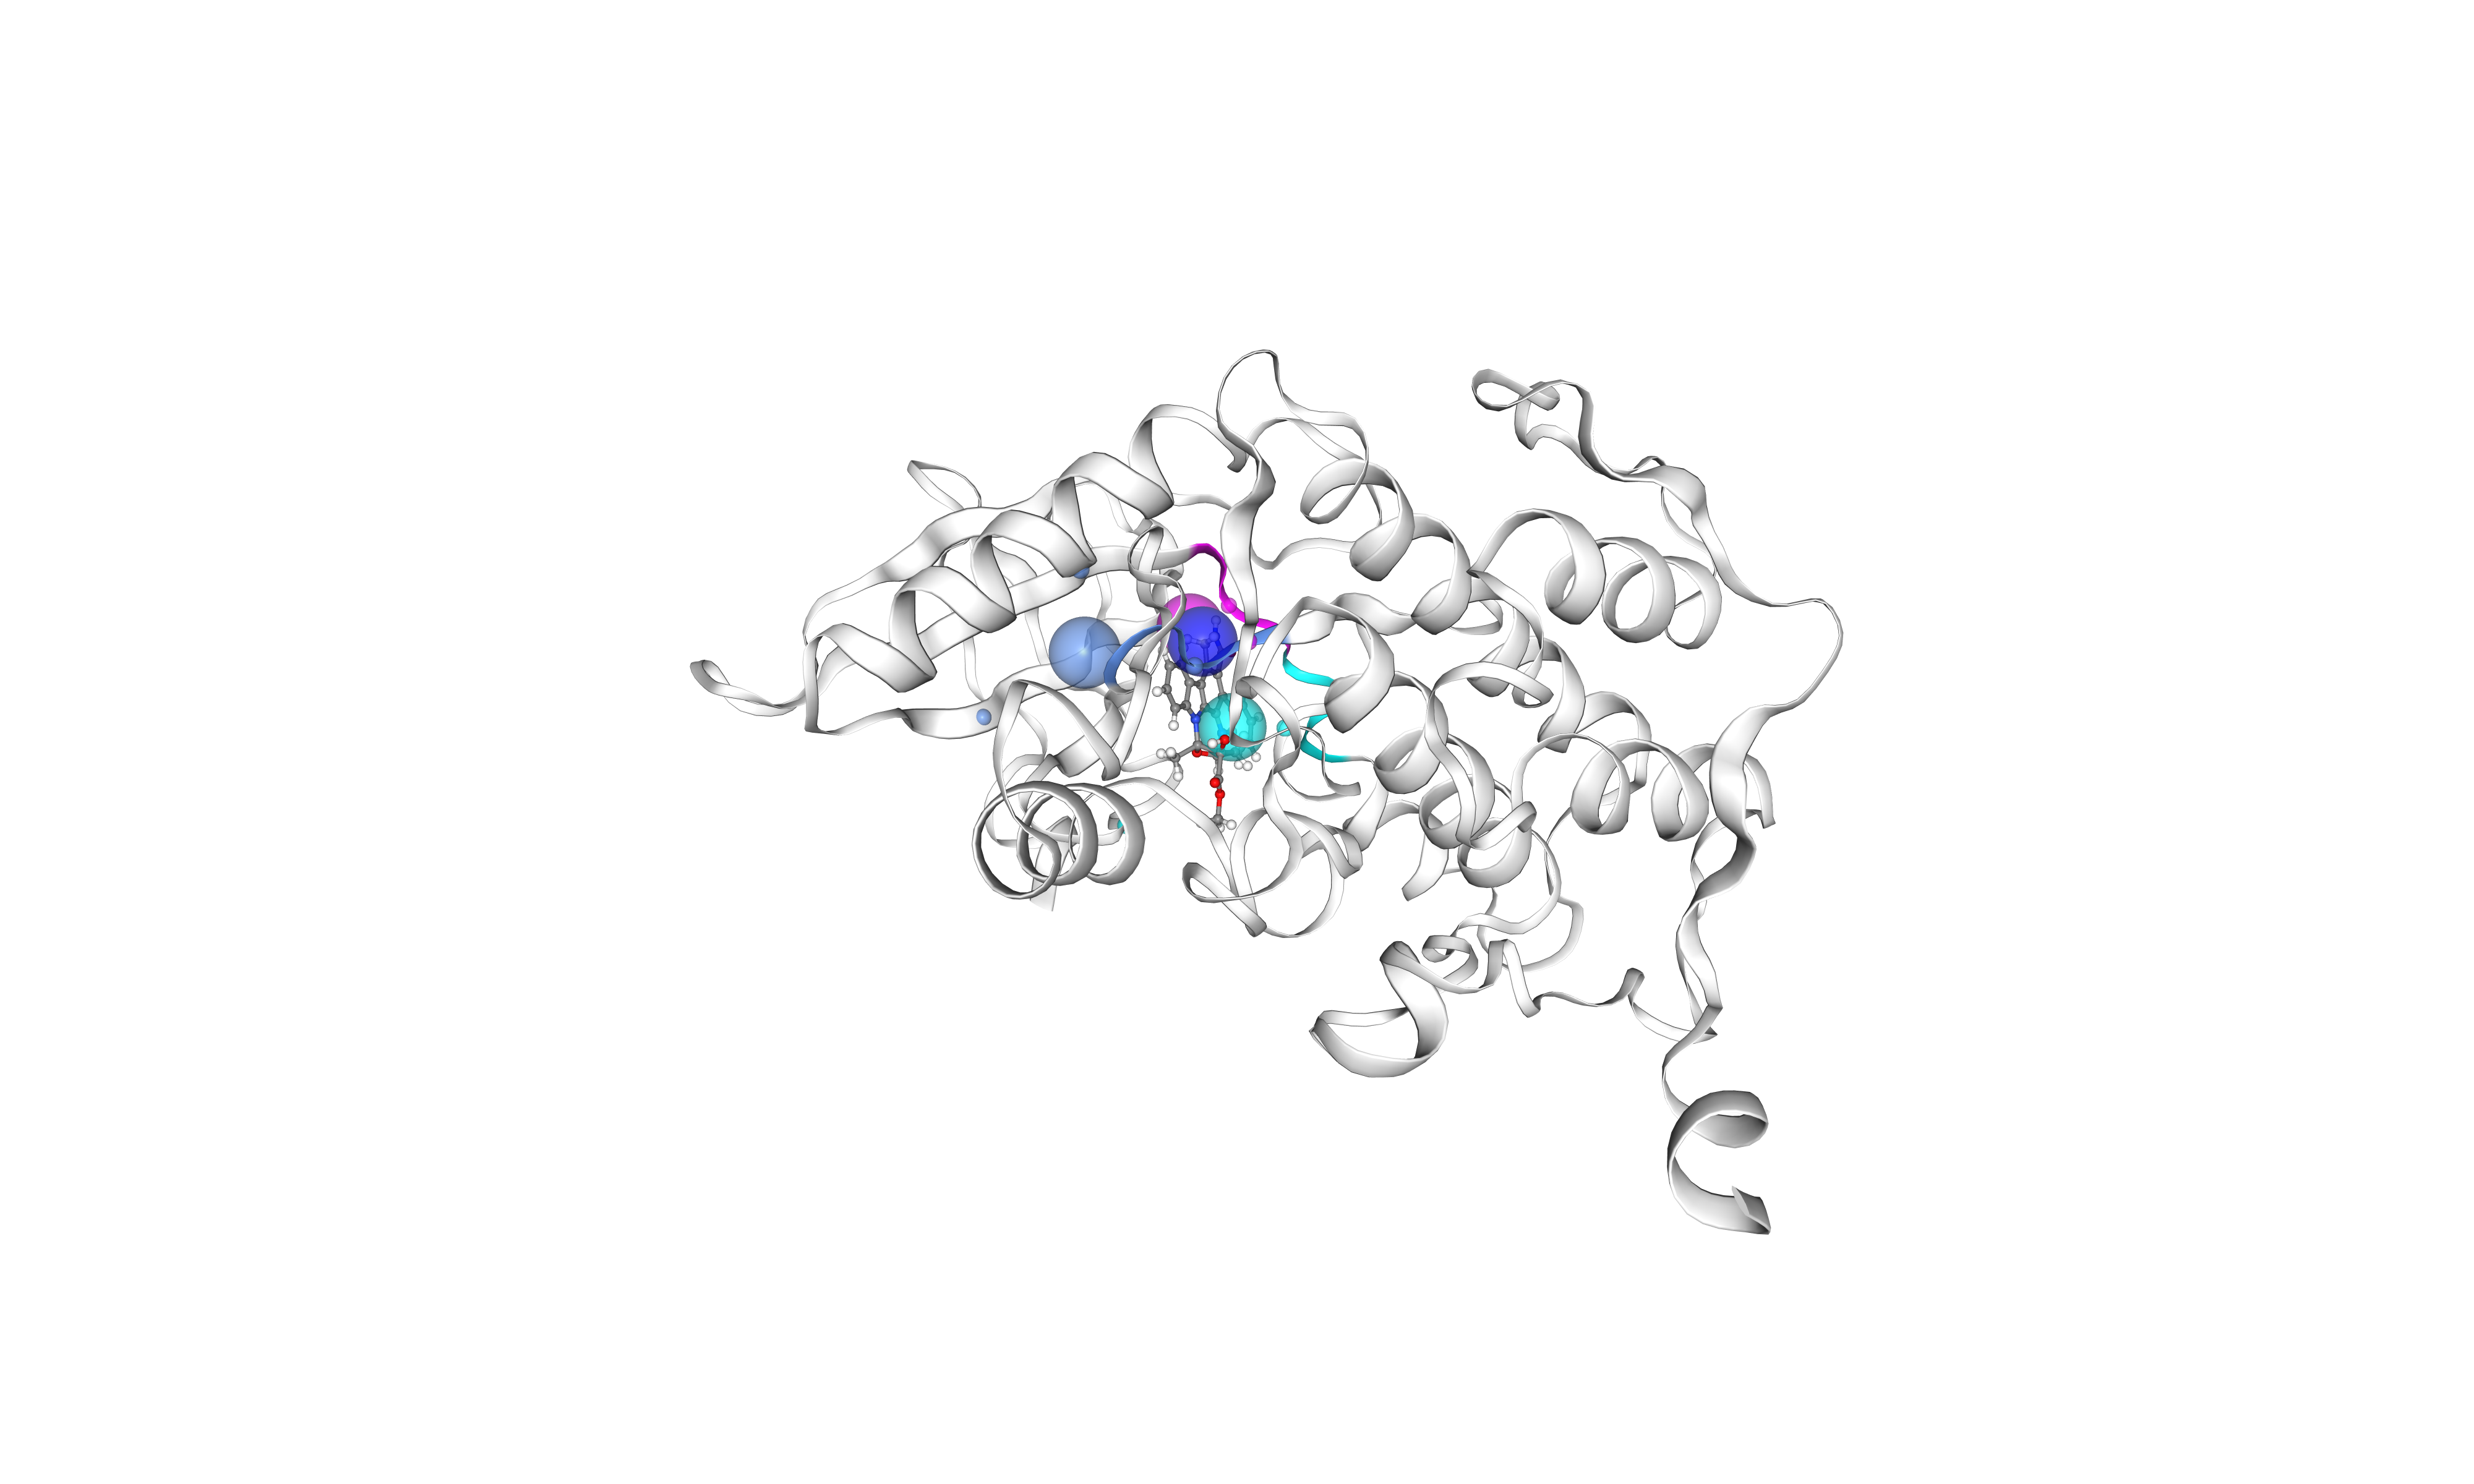

In [18]:
# Static output
viewer.viewer._display_image()

## KLIFS pocket (`KlifsPocket` class)

The `KlifsPocket` class is a child of the `Pocket` class, setting the kinase pocket regions as defined by KLIFS. 

![ba](https://klifs.net/images/faq/colors.png)

_Figure 1_: Kinase pocket regions as defined by KLIFS (taken from the [KLIFS publication](https://pubs.acs.org/doi/abs/10.1021/jm400378w))

Define subpockets (name and color) based on user-defined KLIFS residue IDs.

In [19]:
subpockets = {
    "anchor_residue.klifs_ids": [[16, 47, 80], [19, 24, 81], [6, 48, 75]],
    "subpocket.name": ["hinge_region", "dfg_region", "front_pocket"],
    "subpocket.color": ["magenta", "cornflowerblue", "cyan"]
}
subpockets = pd.DataFrame(subpockets)
subpockets

,anchor_residue.klifs_ids,subpocket.name,subpocket.color
0,"[16, 47, 80]",hinge_region,magenta
1,"[19, 24, 81]",dfg_region,cornflowerblue
2,"[6, 48, 75]",front_pocket,cyan


In [20]:
kinase_pocket = KlifsPocket.from_structure_klifs_id(structure_klifs_id, subpockets)

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


### Visualize pocket with all KLIFS-defined regions

In [21]:
viewer = PocketViewer()
viewer.add_pocket(kinase_pocket)

NGLWidget()

In [22]:
viewer.viewer.render_image(),

(Image(value=b'', width='99%'),)

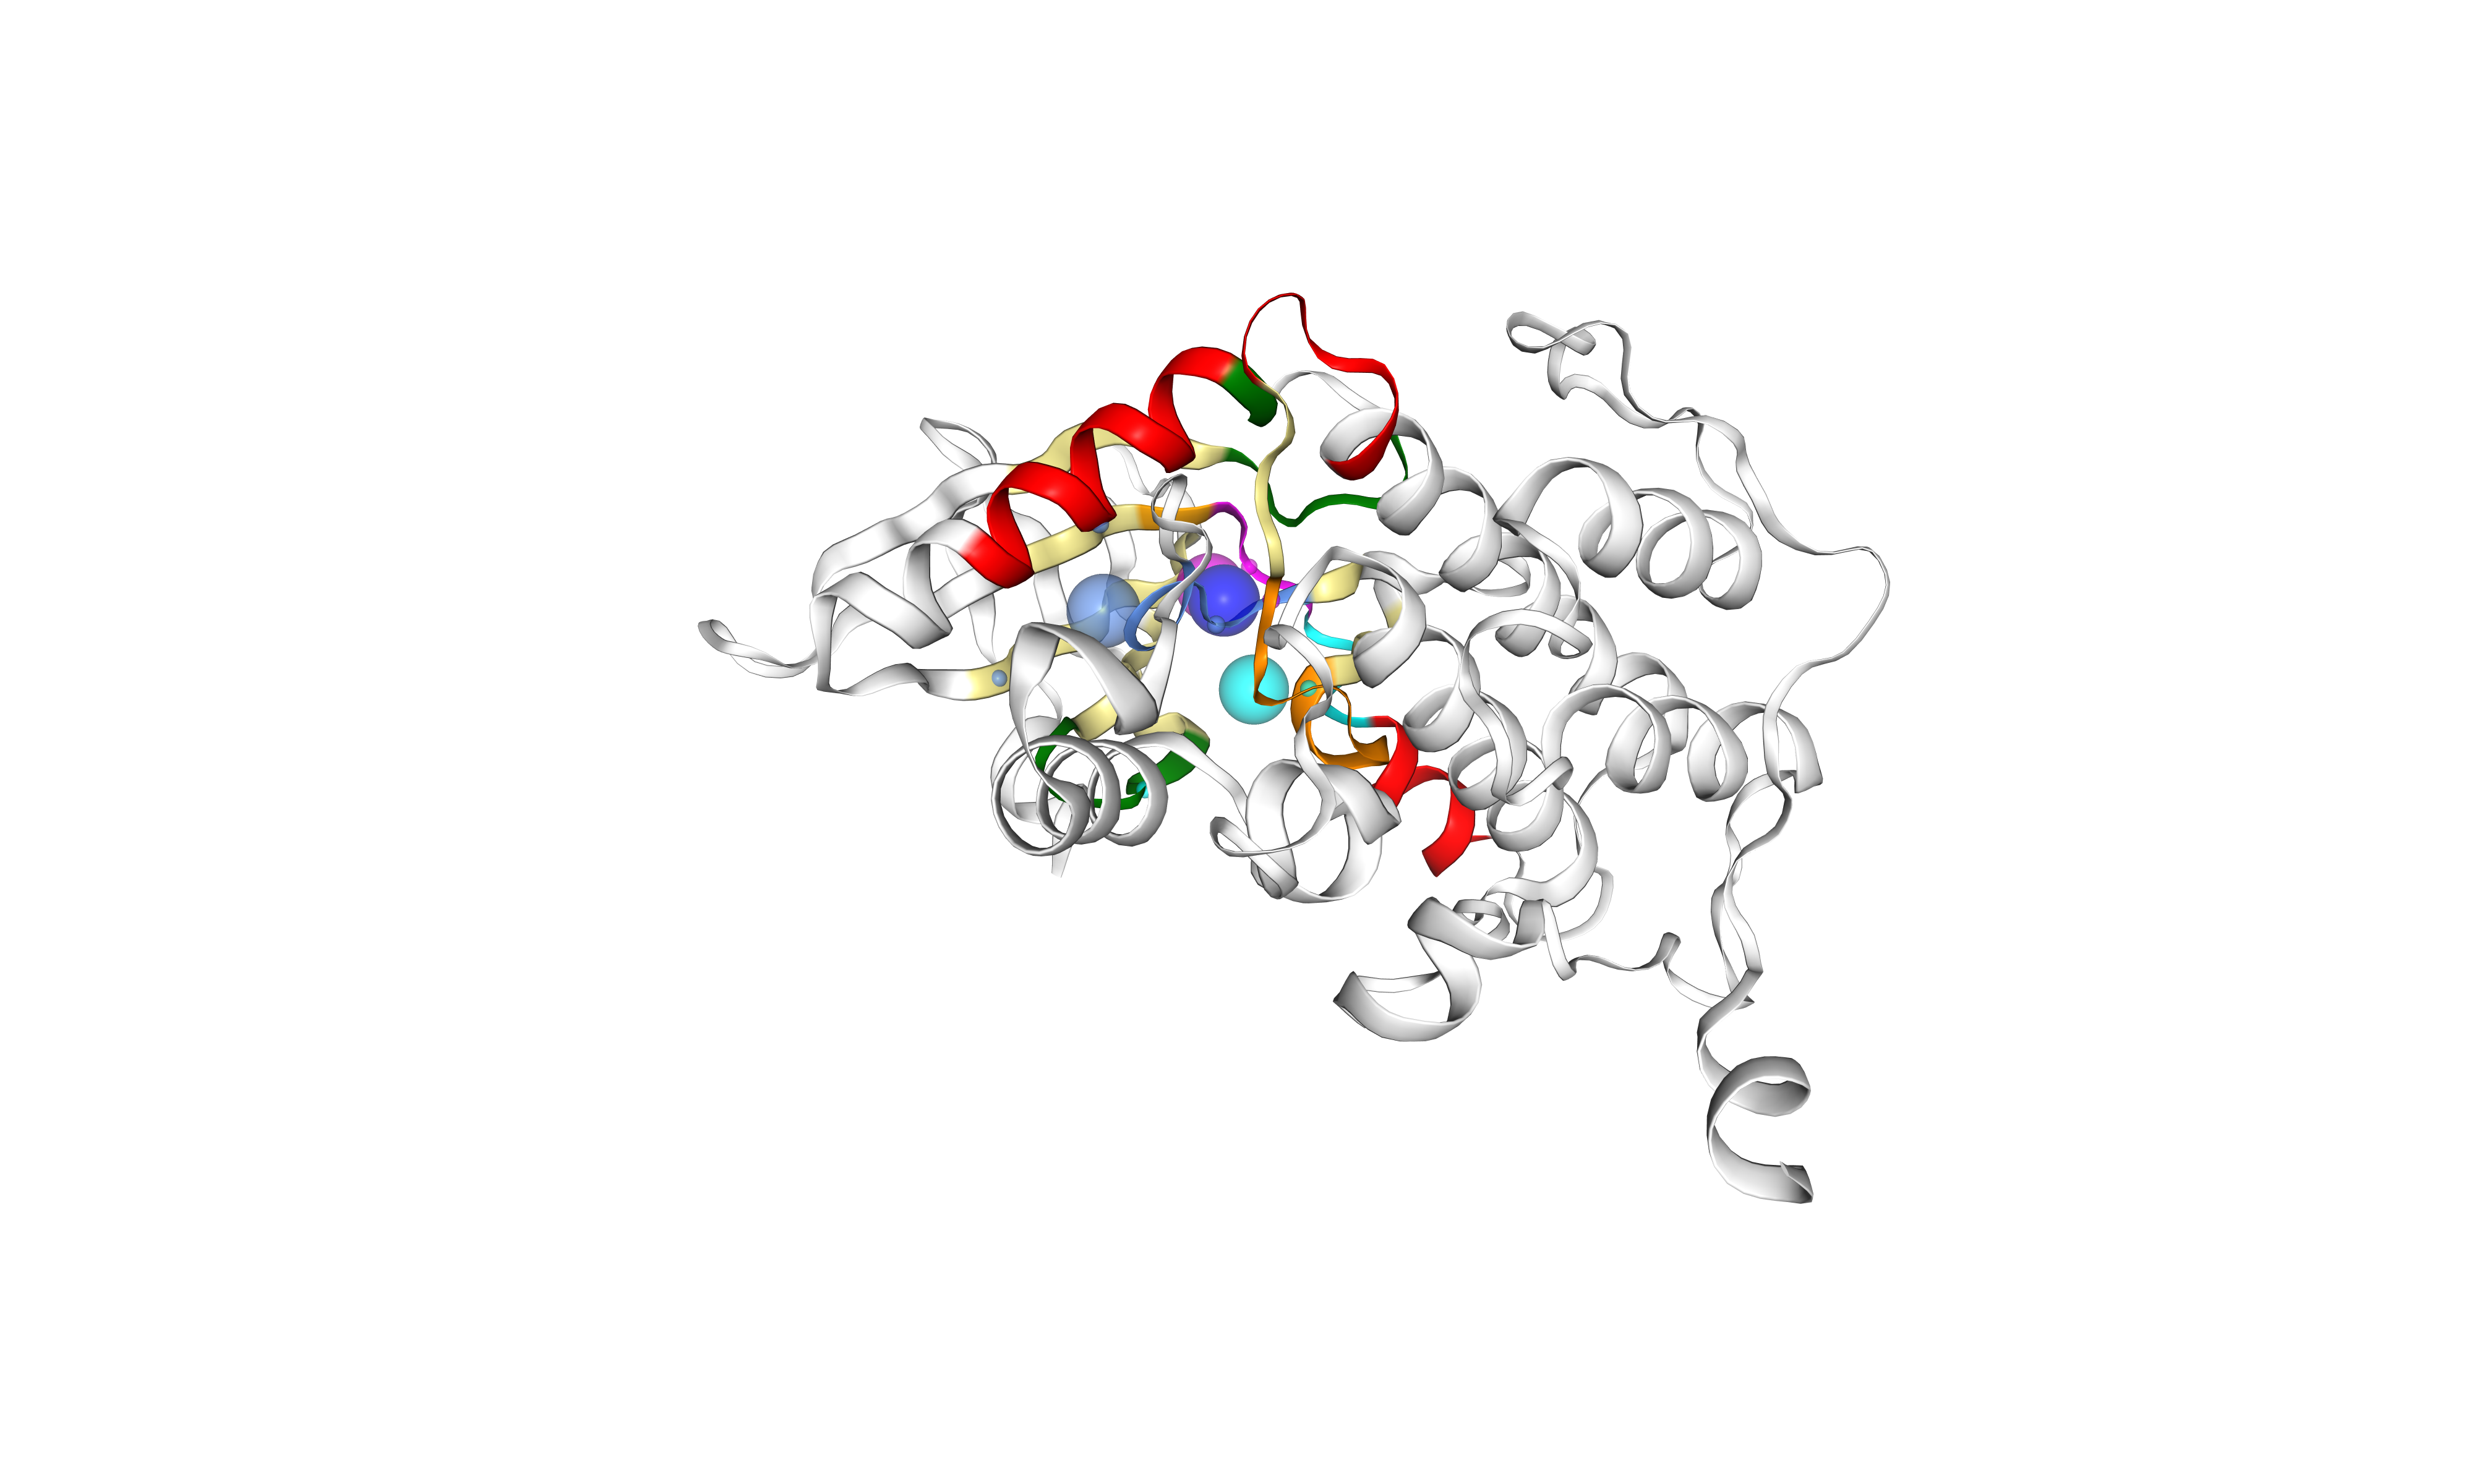

In [23]:
# Static output
viewer.viewer._display_image()